In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, vmap, grad, jit, value_and_grad
import jax.scipy as jscp
from jax.lax import scan, stop_gradient
import flax
import flax.linen as nn
import optax

import itertools
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from jax.nn import softplus, sigmoid, tanh, softmax
from jax.scipy.special import logit

In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Overdamped Langevin Dynamics

In [3]:
def fn_force(param_k, param_u_c, param_u_h, u):
    '''
    Calculate interaction force
    param_k: spring constant
    param_u_c: "saddle" point between two wells
    param_u_h: minimum of the second well 
    (param_u_h > param_u_c)
    u: elongation
    '''
    force = (u <= param_u_c) * param_k * u + (u > param_u_c) * param_k * (u - param_u_h)
    return force

def one_step(states, lambda_t):
    # lambda_t is the position of the n-th particle
    key, X_temp, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian = states
    
    key, subkey = random.split(key)  # generate a new key
    dBt = coeff_Brownian * random.normal(subkey, (10 - 1, ))

    X_temp_new = np.zeros_like(X_temp)
    X_temp_new = X_temp_new.at[-1].set(lambda_t)
    X_temp_new = X_temp_new.at[1:-1].set(X_temp[1:-1] + 1/param_eta * (fn_force(param_k,param_u_c, param_u_h,X_temp[2:]-X_temp[1:-1]-param_L0) \
                                        - fn_force(param_k,param_u_c, param_u_h,X_temp[1:-1]-X_temp[:-2]-param_L0)) * dt + dBt * np.sqrt(dt))
    vel_temp = (X_temp_new - X_temp) / dt
    Fex_temp = fn_force(param_k, param_u_c, param_u_h, X_temp_new[-1] - X_temp_new[-2] - param_L0)\
                            + param_eta * vel_temp[-1] + param_eta * coeff_Brownian * random.normal(subkey, (1, ))[0]

    states = key, X_temp_new, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian
    return states, (X_temp_new, vel_temp, Fex_temp) 

def OneTrjSim_scan(t, num_par, param_L_tot, param_L0, param_eta, param_k, param_u_c, param_u_h, param_kB_T, protocol,
                    seed):
    Nt = t.shape[0]  # number of time mesh
    coeff_Brownian = np.sqrt(2 * param_kB_T / param_eta)
    key = random.PRNGKey(seed[0])

    X0 = np.linspace(0, param_L_tot,num_par + 1)  # initial condition
    # first equilibrate the system
    dt = 0.02
    init = key, X0, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian*4
    _, (X, _, _) = scan(one_step,init,np.ones(10000)*param_L_tot)
    X0 = X[-1,:]
    del X
    dt = t[1] - t[0]
    init = key, X0, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian
    _, (X, _, _) = scan(one_step,init,np.ones(20000)*param_L_tot)
    X0 = X[-1,:]
    del X
    init = key, X0, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian
    _, (X, _, _) = scan(one_step,init,np.ones(20000)*param_L_tot)
    # time integration
    X0 = X[-1,:]
    dt = t[1] - t[0]
    init = key, X0, num_par, dt, param_L0, param_eta, param_k, param_u_c, param_u_h, coeff_Brownian
    _, (X, vel, Fex) = scan(one_step,init,protocol)
    return X, Fex, vel

def DoubleWellSim(t, num_sim, num_par, param_L_tot, param_L0, param_eta, param_k, param_u_c, param_u_h, param_kB_T,
                        protocol, seed, ):
    X, Fex, vel = vmap(OneTrjSim_scan,in_axes=[None,None,None,None,None,None,None,None,None,None,0])\
                (t, num_par, param_L_tot, param_L0, param_eta, param_k, param_u_c, param_u_h, param_kB_T, protocol, seed)
    X = np.transpose(X, [1, 2, 0])
    X = (X[:, 1:, :] - X[:, :-1, :] - param_L0) / param_L0
    vel = np.transpose(vel, [1, 2, 0])
    Fex = np.transpose(Fex, [1, 0])
    return X, Fex, vel[:,1:,:]

# NN Modules

In [4]:
class MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for size in self.layers[:-1]:
            x = nn.Dense(size)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layers[-1])(x)
        return x

class INN_MLP(nn.Module):
    layers: list

    @nn.compact
    def __call__(self, x):
        for size in self.layers[:-1]:
            x = nn.Dense(size)(x)
            x = nn.softplus(x)
        x = nn.Dense(self.layers[-1])(x)
        return x
    
class PICINN_MLP(nn.Module):
    layers: list
    def setup(self):
        self.in_size = self.layers[0]
        self.out_size = self.layers[-1]
        self.hidden_layers = self.layers[1:-1]
        self.num_layers = len(self.hidden_layers)

    @nn.compact
    def __call__(self, w, z): # convext, non-convex
        z_size = z.shape[-1]                 # Size of the input z
        w_size = w.shape[-1]                 # Size of the input w
        input_z = z.reshape(-1, z_size)  # Shape: (batch_size, z_size)
        input_w = w.reshape(-1, w_size)            # Shape: (batch_size, w_size)

        # Input layer parameters
        W_zx = self.param('input_layer_w_zx', nn.initializers.xavier_uniform(), (z_size, self.hidden_layers[0]))
        b_zx = self.param('input_layer_b_zx', nn.initializers.zeros, (self.hidden_layers[0],))
        W_x = self.param('input_layer_w_x', nn.initializers.xavier_uniform(), (z_size, self.hidden_layers[0]))
        W_w = self.param('input_layer_w_w', nn.initializers.xavier_uniform(), (w_size, self.hidden_layers[0]))
        W_wx = self.param('input_layer_w_wx', nn.initializers.xavier_uniform(), (z_size, w_size))
        b_wx = self.param('input_layer_b_wx', nn.initializers.zeros, (w_size,))
        b = self.param('input_layer_b', nn.initializers.zeros, (self.hidden_layers[0],))

        # Input layer computations
        x_hidden = nn.softplus(np.dot(input_z, W_zx) + b_zx)
        y_hidden = nn.softplus(np.dot(np.multiply(input_w, np.dot(input_z, W_wx) + b_wx), W_w) + np.dot(input_z, W_x) + b)

        # Hidden layers computations
        for i in range(self.num_layers - 1):
            W_zx = self.param(f'hidden_layers_w_zx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            b_zx = self.param(f'hidden_layers_b_zx_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))
            
            W_x = self.param(f'hidden_layers_w_x_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            
            W_y = self.param(f'hidden_layers_w_y_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            # Constrain the weights to be non-negative
            W_y = np.where(W_y < 0, np.exp(W_y - 5.0), W_y + np.exp(-5.0))
            
            W_yx = self.param(f'hidden_layers_w_yx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], self.hidden_layers[i+1]))
            b_yx = self.param(f'hidden_layers_b_yx_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))
            
            W_w = self.param(f'hidden_layers_w_w_{i}', nn.initializers.xavier_uniform(), (w_size, self.hidden_layers[i+1]))
            
            W_wx = self.param(f'hidden_layers_w_wx_{i}', nn.initializers.xavier_uniform(), (self.hidden_layers[i], w_size))
            b_wx = self.param(f'hidden_layers_b_wx_{i}', nn.initializers.zeros, (w_size,))
            
            b = self.param(f'hidden_layers_b_{i}', nn.initializers.zeros, (self.hidden_layers[i+1],))

            # Update hidden layers
            y_hidden = nn.softplus(np.dot(np.multiply(y_hidden, nn.softplus(np.dot(x_hidden, W_yx) + b_yx)), W_y.T) \
                                    + np.dot(np.multiply(input_w, np.dot(x_hidden, W_wx) + b_wx), W_w) + np.dot(x_hidden, W_x) + b)
            x_hidden = nn.softplus(np.dot(x_hidden, W_zx) + b_zx)

        # Output layer parameters
        W_x = self.param('output_layer_w_x', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))         
        
        W_yx = self.param('output_layer_w_yx', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))
        b_yx = self.param('output_layer_b_yx', nn.initializers.zeros, (self.out_size,))
        
        W_y = self.param('output_layer_w_y', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], self.out_size))
        # Constrain the weights to be non-negative
        W_y = np.where(W_y < 0, np.exp(W_y - 5.0), W_y + np.exp(-5.0))
        
        W_w = self.param('output_layer_w_w', nn.initializers.xavier_uniform(), (w_size, self.out_size))
        
        W_wx = self.param('output_layer_w_wx', nn.initializers.xavier_uniform(), (self.hidden_layers[-1], w_size))
        b_wx = self.param('output_layer_b_wx', nn.initializers.zeros, (w_size,))
        
        b = self.param('output_layer_b', nn.initializers.zeros, (self.out_size,))

        # Final output computation
        y_out = np.dot(np.multiply(y_hidden, nn.softplus(np.dot(x_hidden, W_yx) + b_yx)), W_y) \
                + np.dot(np.multiply(input_w, np.dot(x_hidden, W_wx) + b_wx), W_w) + np.dot(x_hidden, W_x) + b
        return y_out  # Return scalar output

# Past-future IB



In [5]:
class IB():
    def __init__(self,dataset,num_cg,layers_encoder,layers_encoder2,layers_fe,layers_phi,layers_nf,time_delay,rng_key=random.PRNGKey(0)):
        # load training data
        self.t = dataset[0]
        self.delta_t = self.t[1] - self.t[0]
        self.t = onp.reshape(self.t, [1, -1])
        X_temp = dataset[1]
        self.Fex = dataset[2]
        self.Fex = self.Fex[:,:,None,None]
        self.vel = dataset[3]
        self.L0 = dataset[4]
        self.eta = dataset[5]

        # length of the dataset
        self.Nu = X_temp.shape[0]
        self.Nt = X_temp.shape[1]
        self.Npar = X_temp.shape[2]
        self.Nsim = X_temp.shape[3]
        self.Nhidden = layers_nf[-1] // 3
        self.num_cg = num_cg

        # scaling X
        self.X_mean = X_temp.mean()
        self.X_std = X_temp.std()  
        self.X_scaled = (X_temp - self.X_mean) / self.X_std

        # calc mean
        self.mean = X_temp.mean(axis=(3,4))[:, :, :, None]

        # set delta t (should be an integer)
        self.time_delay = time_delay

        # set up encoder and decoder network initialization and evaluation functions
        # Initialize networks
        self.nn_encoder = MLP([num_cg] + layers_encoder)
        self.nn_encoder2 = MLP(layers_encoder2)
        self.nn_fe = INN_MLP(layers_fe)
        self.nn_phi = PICINN_MLP(layers_phi) 
        self.nn_nf = MLP(layers_nf) # normalizing flows

        # Initialize parameters
        self.rng_key = rng_key
        _, subkey1, subkey2, subkey3, subkey4, subkey5 = random.split(rng_key, 6)
        params_encoder = self.nn_encoder.init(subkey1, np.ones([1]))
        params_encoder2 = self.nn_encoder2.init(subkey2, np.ones([layers_encoder2[0]]))
        params_fe = self.nn_fe.init(subkey3, np.ones([2]))
        params_phi = self.nn_phi.init(subkey4, np.ones([2]), np.ones([2]))
        params_nf = self.nn_nf.init(subkey5, np.ones([2]))
        # During initialization
        self.params = {'encoder': params_encoder, 'encoder2': params_encoder2, 'fe': params_fe, 'phi': params_phi, 'nf': params_nf}

        # Set up optimizer
        self.opt_init, self.opt_update = optax.adam(5e-5) #5e-5
        self.opt_state = self.opt_init(self.params)

        # Logger to monitor the loss function
        self.loss_log = []
        self.loss_pdf_log = []
        self.loss_eps_log = []
        self.loss_alpha_log = []
        self.itercount = itertools.count()

        # define all vectorized calc derivatives functions
        self.vec_dfe_dphi()

        # clipping
        self.large = 30

        # for zero fix
        self.mean_zero = self.mean[0,:1,0,0]
        self.g_zero = onp.zeros(1) # for g
        self.internal_var_zero = onp.zeros(1) 

        # mean and std of mean
        self.eps_mean = onp.array(self.mean.mean())
        self.eps_std = onp.array(self.mean.std())
        # mean and std of internal variables
        self.internal_var_mean = 0.0 
        self.internal_var_std = 1.0 
        
        # scales of free energy and dissipation potential
        self.fe_scale = onp.array(self.Fex.std() * self.eps_std * self.L0)
        self.phi_scale = onp.array(self.fe_scale * 1.0 / self.internal_var_std)

        # scales of g
        self.g_vel_scale = onp.array(self.phi_scale / self.vel.std())
        self.g_vel_mean = onp.array(0.5 * self.g_vel_scale)
        self.g_internal_var_dot_scale = onp.array(self.phi_scale / self.internal_var_std)
        self.g_internal_var_dot_mean = onp.array(0.5 * self.g_internal_var_dot_scale)

        # loss weights
        self.factor_m_log = 0.001
        self.factor_eps = 1 
        self.factor_alpha = 1
    
    def get_norm_fac(self):
        return [self.factor_m_log, self.factor_eps, self.factor_alpha]
    
    def load_norm_fac(self, norm_fac):
        # load data
        self.factor_m_log, self.factor_eps, self.factor_alpha = norm_fac
        return

    # calc free energy fe 
    def net_fe_no_zero_fix(self, params_fe, eps, internal_var, norm_fac):
        eps_mean, eps_std, internal_var_mean, internal_var_std, _, _, _ = norm_fac
        # normalize input
        eps = (eps - eps_mean) / eps_std
        internal_var = (internal_var - internal_var_mean) / internal_var_std
        inputs = np.concatenate([eps, internal_var],axis=0)
        fe = self.nn_fe.apply(params_fe, inputs)
        return fe[0]

    def net_fe(self, params_fe, eps, internal_var, norm_fac):
        _, _, _, _, fe_scale, mean_zero, internal_var_zero = norm_fac
        fe = self.net_fe_no_zero_fix(params_fe, eps, internal_var, norm_fac) 
        fe_zero = self.net_fe_no_zero_fix(params_fe, mean_zero, internal_var_zero, norm_fac) 
        return (fe - fe_zero) * fe_scale
    
    # calc dissipation potential phi 
    def net_phi_no_zero_fix(self, params_phi, g_vel, g_internal_var_dot, eps, internal_var, norm_fac):
        eps_mean, eps_std, internal_var_mean, internal_var_std, g_vel_mean, g_vel_scale, g_internal_var_dot_mean, g_internal_var_dot_scale, _, _ = norm_fac
        # normalizing input
        eps = (eps - eps_mean) / eps_std
        internal_var = (internal_var - internal_var_mean) / internal_var_std
        g_vel = (g_vel - g_vel_mean) / g_vel_scale
        g_internal_var_dot = (g_internal_var_dot - g_internal_var_dot_mean) / g_internal_var_dot_scale
        
        inputs_nonconvex = np.concatenate([eps, internal_var],axis=0)
        inputs_convex = np.concatenate([g_vel, g_internal_var_dot],axis=0)
        phi = self.nn_phi.apply(params_phi, inputs_convex, inputs_nonconvex) 
        return phi[0][0]

    def net_phi(self, params_phi, g_vel, g_internal_var_dot, eps, internal_var, norm_fac):
        _, _, _, _, _, _, _, _, phi_scale, g_zero = norm_fac
        phi = self.net_phi_no_zero_fix(params_phi, g_vel, g_internal_var_dot, eps, internal_var, norm_fac)
        phi_zero = self.net_phi_no_zero_fix(params_phi, g_zero, g_zero, eps, internal_var, norm_fac)
        dphi_fix = grad(self.net_phi_no_zero_fix,1)(params_phi, g_zero, g_zero, eps, internal_var, norm_fac) * g_vel + \
                    grad(self.net_phi_no_zero_fix,2)(params_phi, g_zero, g_zero, eps, internal_var, norm_fac) * g_internal_var_dot
        return (phi - phi_zero - dphi_fix)[0] * phi_scale 

    # vmap all derivatives
    def vec_dfe_dphi(self):
        self.vec_calc_dfe_deps = vmap(vmap(vmap(grad(self.net_fe, 1),in_axes=[None,0,0,None]),in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
        self.vec_calc_dfe_dinternal = vmap(vmap(vmap(grad(self.net_fe, 2),in_axes=[None,0,0,None]),in_axes=[None,0,0,None]),in_axes=[None,0,0,None])
        self.vec_calc_dphi_dg_vel = vmap(vmap(vmap(grad(self.net_phi, 1),in_axes=[None,0,0,0,0,None]),in_axes=[None,0,0,0,0,None]),in_axes=[None,0,0,0,0,None])
        self.vec_calc_dphi_dg_internal_dot = vmap(vmap(vmap(grad(self.net_phi, 2),in_axes=[None,0,0,0,0,None]),in_axes=[None,0,0,0,0,None]),in_axes=[None,0,0,0,0,None])
        self.get_loss = jit(self._get_loss)
        self.step = jit(self._step)
        return 

    # VONNs calc derivatives
    def VONNs_drv(self, params_fe, params_phi, eps, internal_var, F_ex, norm_fac_fe, norm_fac_phi, _L0):
        # calc derivatives
        dfe_deps = self.vec_calc_dfe_deps(params_fe, eps, internal_var, norm_fac_fe)
        dfe_dinternal = self.vec_calc_dfe_dinternal(params_fe, eps, internal_var, norm_fac_fe)

        F_ex = F_ex[:,:,:,None]
        # obtain g from f derivatives
        g_vel_neighbor = (dfe_deps[:,:,1:,:] - dfe_deps[:,:,:-1,:]) / _L0 
        g_vel_bc = F_ex - dfe_deps[:,:,-1:,:] / _L0
        g_vel = np.concatenate([g_vel_neighbor,g_vel_bc], axis=2)
        g_internal_var_dot = - dfe_dinternal

        # predict vel (with derivatives clipping)
        vel_nn = self.vec_calc_dphi_dg_vel(params_phi, g_vel, g_internal_var_dot, eps, internal_var, norm_fac_phi)
        vel_nn = np.concatenate([np.zeros([vel_nn.shape[0],vel_nn.shape[1],1,1]),vel_nn],axis=2)
        eps_dot_nn = np.clip((vel_nn[:,:,1:,:] - vel_nn[:,:,:-1,:]) / _L0, a_min=-self.large, a_max=self.large)
        # predict alpha dot
        alpha_dot_nn = np.clip(self.vec_calc_dphi_dg_internal_dot(params_phi, g_vel, g_internal_var_dot, eps, internal_var, norm_fac_phi),\
                                    a_min=-self.large, a_max=self.large)    
        return eps_dot_nn, alpha_dot_nn
    
    # function of the scan loop
    def time_int(self, states, F_ex):
        params_fe, params_phi, eps, alpha, norm_fac_fe, norm_fac_phi, _L0  = states    
        # calc derivatives
        eps_dot_nn, alpha_dot_nn = self.VONNs_drv(params_fe, params_phi, eps, alpha, F_ex, norm_fac_fe, norm_fac_phi, _L0)
        # update states
        eps = eps + eps_dot_nn * self.delta_t
        alpha = alpha + alpha_dot_nn * self.delta_t
        return (params_fe, params_phi, eps, alpha, norm_fac_fe, norm_fac_phi, _L0), (eps, alpha) 

    def calc_internal_var(self, params_encoder, params_encoder2, X_scaled):
        internal_var = self.nn_encoder.apply(params_encoder, X_scaled).mean(axis=-2)
        internal_var = self.nn_encoder2.apply(params_encoder2, internal_var)
        return internal_var

    # loss function
    def _get_loss(self, params, batch):
        norm_fac_fe, norm_fac_phi, factor_m_log, factor_eps, factor_alpha, eps, X_scaled, _Fex, _L0 = batch

        params_encoder = params['encoder']
        params_encoder2 = params['encoder2']
        params_fe = params['fe']
        params_phi = params['phi']
        params_nf = params['nf']

        # nearest neighbor connection
        alpha = self.calc_internal_var(params_encoder, params_encoder2, X_scaled)
        
        # predict future states with VONNs 
        init = params_fe, params_phi, eps[:,:1,:,:], alpha[:,:1,:,:], norm_fac_fe, norm_fac_phi, _L0
        _, (predict_eps, predict_alpha) = scan(self.time_int, init, np.transpose(_Fex[:,:-1,:,:],axes=[1,0,2,3]))
        predict_eps = np.transpose(predict_eps[:,:,0,:,:],axes=[1,0,2,3])
        predict_alpha = np.transpose(predict_alpha[:,:,0,:,:],axes=[1,0,2,3])
        
        # predict future eps
        loss_eps = ((predict_eps - eps[:,1:,:,:])**2).mean()

        # predict future alpha
        loss_alpha = ((predict_alpha - alpha[:,1:,:,:])**2).mean()

        # apply nn's
        mean_int_var = np.concatenate([eps, alpha], axis=3)
        predict_nf = self.nn_nf.apply(params_nf,mean_int_var) 
        predict_w = softmax(predict_nf[:,:,:,:self.Nhidden],axis=-1)[:,:,:,None,:]
        predict_a = np.exp(predict_nf[:,:,:,self.Nhidden:2*self.Nhidden])[:,:,:,None,:]
        predict_b = predict_nf[:,:,:,-self.Nhidden:][:,:,:,None,:]

        # normalizing flows
        linear_X = predict_a * X_scaled + predict_b
        pre_activate = np.sum(predict_w * sigmoid(linear_X),axis=-1)
        z = logit(pre_activate)
        vol_factor = (1/pre_activate + 1/(1-pre_activate)) * np.sum(predict_w * predict_a \
                    * sigmoid(linear_X) * (1-sigmoid(linear_X)),axis=-1)

        # minus log likelihood
        m_log_pdf = (0.5 * np.square(z) - np.log(vol_factor)).mean()
        loss = factor_m_log * m_log_pdf + factor_eps * loss_eps + factor_alpha * loss_alpha
        return loss, m_log_pdf, loss_eps, loss_alpha

    # get loss function
    def loss(self, params, batch):
        loss, _, _, _ = self.get_loss(params, batch)
        return loss

    # Define a compiled update step
    def _step(self, params, opt_state, batch):
        g = grad(self.loss)(params, batch)
        updates, opt_state = self.opt_update(g, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    
    def train(self, num_epochs=100):   
        # normalizing factors
        norm_fac_fe = self.eps_mean, self.eps_std, self.internal_var_mean, self.internal_var_std, self.fe_scale, self.mean_zero, self.internal_var_zero 
        norm_fac_phi = self.eps_mean, self.eps_std, self.internal_var_mean, self.internal_var_std, \
                        self.g_vel_mean, self.g_vel_scale, self.g_internal_var_dot_mean, self.g_internal_var_dot_scale, self.phi_scale, self.g_zero

        pbar = trange(num_epochs)
        for epoch in pbar:
            self.rng_key, _ = random.split(self.rng_key)
            id = random.randint(self.rng_key, (1,), minval=0, maxval=self.Nu)[0]
            id_t = random.randint(self.rng_key, (1,), minval=0, maxval=self.Nt-self.time_delay)[0]
            batch = norm_fac_fe, norm_fac_phi, self.factor_m_log, self.factor_eps, self.factor_alpha, self.mean[id:id+1,id_t:id_t+self.time_delay,:,:],\
                    self.X_scaled[id:id+1,id_t:id_t+self.time_delay,:,:,:], self.Fex[id:id+1,id_t:id_t+self.time_delay,:,:], self.L0         
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)

            if epoch % 100 == 0:
                loss, loss_pdf, loss_eps, loss_alpha = self.get_loss(self.params, batch)
                self.loss_log.append(loss)
                self.loss_pdf_log.append(loss_pdf)
                self.loss_eps_log.append(loss_eps)
                self.loss_alpha_log.append(loss_alpha)
                print("\n loss = {}".format(loss))

    def get_all_params(self):
        params_encoder = self.params['encoder']
        params_encoder2 = self.params['encoder2']
        params_fe = self.params['fe']
        params_phi = self.params['phi']
        params_nf = self.params['nf']
        return params_encoder, params_encoder2, params_fe, params_phi, params_nf, self.params

    def get_test_predicted_mean_std(self, X_input, t_id, pr_id):
        '''
        X_input: data
        t_id: time index
        pr_id: pair index
        '''
        params_encoder, params_encoder2, _, _, params_nf, _ = self.get_all_params()
        eps = X_input.mean(axis=(2,3))[:, :, None]
        alpha = self.calc_internal_var(params_encoder, params_encoder2, (X_input-self.X_mean)/self.X_std)

        # apply nn's
        mean_int_var = np.concatenate([eps, alpha], axis=2)
        predict_nf = self.nn_nf.apply(params_nf,mean_int_var) 
        predict_w = softmax(predict_nf[t_id,pr_id,:self.Nhidden],axis=-1)[None,:]
        predict_a = np.exp(predict_nf[t_id,pr_id,self.Nhidden:2*self.Nhidden])[None,:]
        predict_b = predict_nf[t_id,pr_id,-self.Nhidden:][None,:]
        return predict_w, predict_a, predict_b

    def solve_OVP(self, X_input, F_ex):
        # retrieve params
        params_encoder, params_encoder2, params_fe, params_phi, _, _ = self.get_all_params()
        
        F_ex = F_ex[:,:,None,None]
        # calc internal_var and mean
        eps = X_input.mean(axis=-2)
        alpha = self.calc_internal_var(params_encoder, params_encoder2, (X_input-self.X_mean)/self.X_std)

        # normalizing factors
        norm_fac_fe = self.eps_mean, self.eps_std, self.internal_var_mean, self.internal_var_std, self.fe_scale, self.mean_zero, self.internal_var_zero 
        norm_fac_phi = self.eps_mean, self.eps_std, self.internal_var_mean, self.internal_var_std, \
                        self.g_vel_mean, self.g_vel_scale, self.g_internal_var_dot_mean, self.g_internal_var_dot_scale, self.phi_scale, self.g_zero
        init = params_fe, params_phi, eps[:,:1,:,:], alpha[:,:1,:,:], norm_fac_fe, norm_fac_phi, self.L0
        _, (eps_nn, alpha_nn) = scan(self.time_int, init, np.transpose(F_ex[:,:-1,:,:],axes=[1,0,2,3]))
        eps_nn = np.transpose(eps_nn[:,:,0,:,:],axes=[1,0,2,3])
        alpha_nn = np.transpose(alpha_nn[:,:,0,:,:],axes=[1,0,2,3]) 
        return eps, alpha, eps_nn, alpha_nn

### Generate data

In [6]:
num_t = 301
t = onp.linspace(0,3,301)

In [7]:
num_sim_ld = 2000
num_sim = 2000
num_par = 10
L_tot = onp.linspace(0.1,0.3,21)
L0 = 0.01
eta = 0.1
k = 1
u_c = 0.01
u_h = 2 * u_c
kB_T = 5e-6
num_u = len(L_tot)
u = 0.05
seed = onp.linspace(0, num_sim_ld - 1, num_sim_ld, dtype=int)[:, None]

X = onp.zeros([num_u, num_t, num_par, num_sim])
Fex_raw = onp.zeros([L_tot.shape[0], num_t, num_sim])
vel_raw = onp.zeros([L_tot.shape[0],num_t,num_par,num_sim])

for i in range(L_tot.shape[0]):
    pull_prt = u * t * (1 - onp.exp(-1*t)) + L_tot[i] # protocol
    X_temp, Fex_raw_temp, vel_raw_temp = DoubleWellSim(t, num_sim_ld, num_par, L_tot[i], L0, eta, k, u_c, u_h, kB_T, pull_prt, seed)
    X[i,:,:,:] = X_temp[:,:,:num_sim]
    Fex_raw[i,:,:] = Fex_raw_temp[:,:num_sim]
    vel_raw[i,:,:,:] = vel_raw_temp[:,:,:num_sim]

Fex = Fex_raw.mean(axis=-1)
vel = vel_raw.mean(axis=-1)
del X_temp, Fex_raw_temp, vel_raw_temp

X = X[:,:,:,:,None]

# change to single precision
X = X.astype('float32')
Fex = Fex.astype('float32')
vel = vel.astype('float32')

In [9]:
pull_prt = u * t * (1 - onp.exp(-1*t)) * (1.0 + 0.20*onp.sin(onp.pi*t)) + L_tot[10] # protocol
X_temp, Fex_raw_temp, vel_raw_temp = DoubleWellSim(t, num_sim_ld, num_par, L_tot[10], L0, eta, k, u_c, u_h, kB_T, pull_prt, seed)
X_sin = X_temp[None,:,:,:num_sim,None]
Fex_sin = (Fex_raw_temp[:,:num_sim].mean(axis=-1))[None,:]
vel_sin = (vel_raw_temp[:,:,:num_sim].mean(axis=-1))[None,:,:]
del X_temp, Fex_raw_temp, vel_raw_temp

### Training

In [8]:
# architecture of the nn's
encoder = [10, 10, 1]
encoder2 = [1, 10, 1]
l_fe = [2,20,20,1] 
l_phi = [2,20,20,1]  
l_nf = [2, 10, 10, 6]
num_cg = 1 # number of springs to be coarse-grained
time_delay = 30 # 300
train_index = onp.linspace(2,18,9,dtype=int) 
dataset = t, X[train_index,:,:,:,:], Fex[train_index, :], vel[train_index,:,:,None], L0, eta
u_set = onp.ones_like(train_index)*u

In [9]:
model = IB(dataset, num_cg, encoder, encoder2, l_fe, l_phi, l_nf, time_delay,rng_key = random.PRNGKey(0)) 
# model.train(num_epochs=200000)

### Save params

In [92]:
# import pickle
# FolderName = './data/IB-VONNs-CNF/'
# FileName= 'IB_VONNs_CNF_params'
# _, _, _, _, _, params_temp = model.get_all_params()
# with open(FolderName+FileName, 'wb') as fp:
#     pickle.dump(params_temp, fp)
# del params_temp

# FileName= 'IB_VONNs_CNF_norm_fac'
# with open(FolderName+FileName, 'wb') as fp:
#     pickle.dump(model.get_norm_fac(), fp)

In [11]:
import pickle

FolderName =  './data/IB-VONNs-CNF/' 
FileName = 'IB_VONNs_CNF_params'
with open(FolderName + FileName, 'rb') as fp:
    params_IB = pickle.load(fp)

FileName= 'IB_VONNs_CNF_norm_fac'
with open(FolderName+FileName, 'rb') as fp:
    norm_fac_log = pickle.load(fp)

model.opt_state = model.opt_init(params_IB)
model.params = params_IB
model.load_norm_fac(norm_fac_log)

### Loss curve

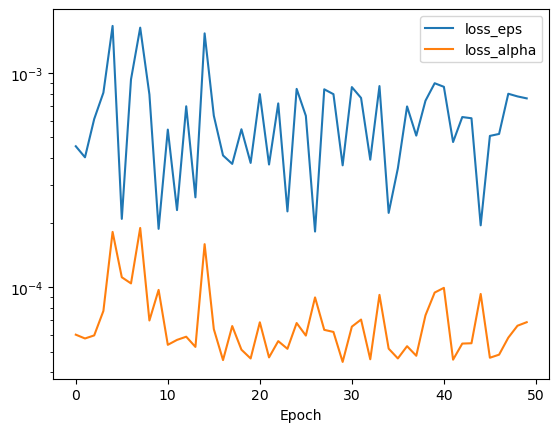

In [43]:
plt.figure()
plt.plot(model.loss_log,label='loss')
# plt.plot(model.loss_pdf_log,label='loss_pdf')
# plt.plot(model.loss_eps_log,label='loss_eps')
# plt.plot(model.loss_alpha_log,label='loss_alpha')
plt.legend()
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

In [12]:
# log-likelihood on test set
norm_fac_fe_test = model.eps_mean, model.eps_std, model.internal_var_mean, model.internal_var_std, \
                     model.fe_scale, model.mean_zero, model.internal_var_zero 
norm_fac_phi_test = model.eps_mean, model.eps_std, model.internal_var_mean, model.internal_var_std, \
            model.g_vel_mean, model.g_vel_scale, model.g_internal_var_dot_mean, model.g_internal_var_dot_scale, model.phi_scale, model.g_zero
# test_index = onp.linspace(2,18,9,dtype=int) # training set
test_index = onp.linspace(3,17,8,dtype=int) # test set
X_test_scaled = (X[test_index,:,:,:,:] - model.X_mean) / model.X_std
mean_test = X[test_index,:,:,:,:].mean(axis=(3,4))[:, :, :, None]
Fex_temp = Fex[test_index,:,None,None]

batch_test = norm_fac_fe_test, norm_fac_phi_test, model.factor_m_log, model.factor_eps, model.factor_alpha, mean_test, X_test_scaled, Fex_temp, model.L0
_, loss_pdf_test, _, _ = model.get_loss(model.params, batch_test)

print(-(loss_pdf_test + 0.5*onp.log(2*onp.pi)))

### Learned mean and std

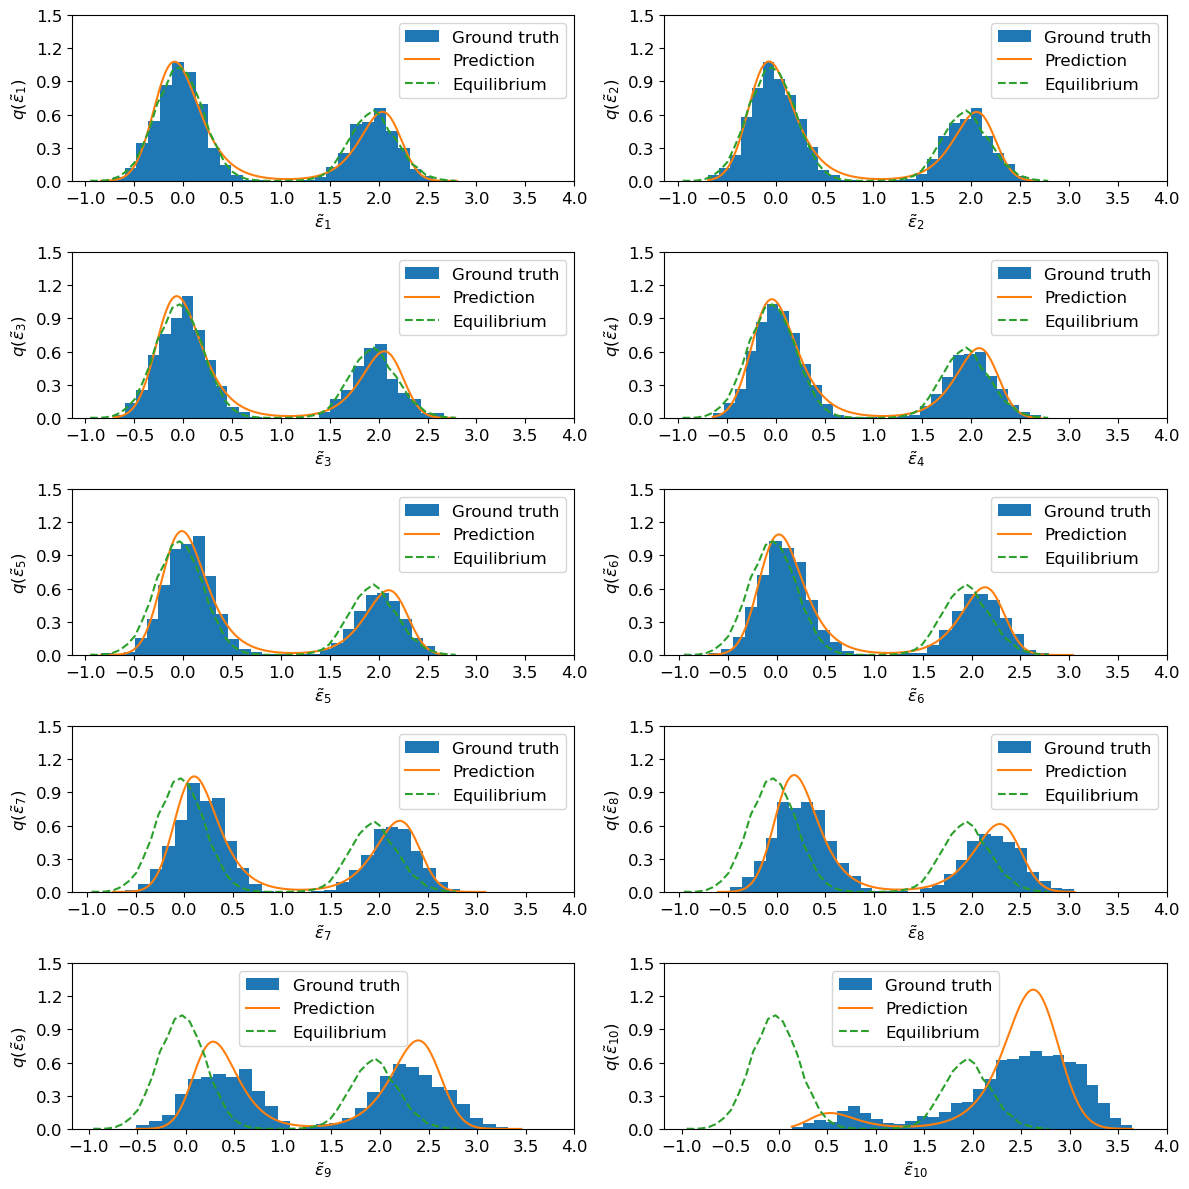

In [14]:
u_index = 7
t_index = 100

plt.figure(figsize=(12,12))

for par_index in range(0,10):
    p_w, p_a, p_b = model.get_test_predicted_mean_std(X[u_index, :, :, :, :], t_index, par_index)
    # future state
    minmax = X[u_index, t_index, par_index, :, 0].max() - X[u_index, t_index, par_index, :, 0].min()
    mean_left = X[u_index, t_index, par_index, :, 0].min() - 0. * minmax
    mean_right = X[u_index, t_index, par_index, :, 0].max() + 0. * minmax
    xspan = onp.linspace(mean_left, mean_right, 300)
    xspan_scaled = (xspan - model.X_mean) / model.X_std
    
    # CNF
    linear_xgrid = p_a* xspan_scaled[:,None] + p_b
    pre_act = np.sum(p_w * sigmoid(linear_xgrid),axis=-1)
    zspan = logit(pre_act)
    vol_fac = (1/pre_act + 1/(1-pre_act)) * np.sum(p_w * p_a * sigmoid(linear_xgrid) * (1-sigmoid(linear_xgrid)),axis=-1)
    predict_pdf = jscp.stats.norm.pdf(zspan) * vol_fac / model.X_std 

    plt.subplot(5, 2, par_index+1)
    plt.hist(X[u_index,t_index,par_index,:],bins=30,density=True,label='Ground truth')
    plt.plot(xspan,predict_pdf,label='Prediction')
    den, edges = onp.histogram(np.ravel(X[u_index,0,:,:]),bins=50,density=True)
    plt.plot(0.5*(edges[1:]+edges[:-1]), den,'--',label='Equilibrium')
    plt.xlabel(r'$\tilde{\varepsilon}_{'+str(par_index+1)+'}$', fontsize=12)
    plt.ylabel(r'$q(\tilde{\varepsilon}_{'+str(par_index+1)+'})$', fontsize=12)
    plt.xticks(ticks=onp.linspace(-1,4.0,11),fontsize=12)
    plt.yticks(ticks=onp.linspace(0,1.5,6),fontsize=12)
    plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

### Profiles of "internal variables"

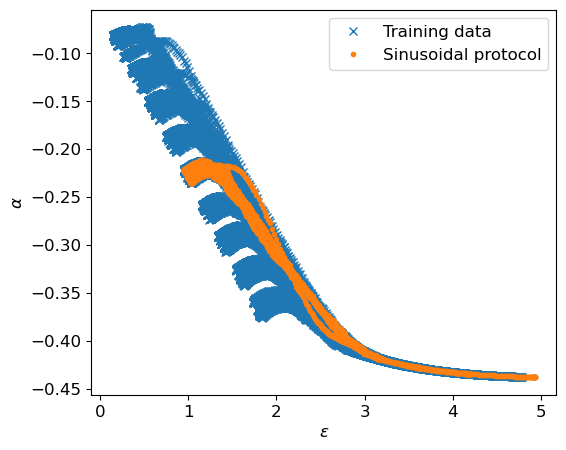

In [19]:
plt.figure(figsize = (6,5))
t_alpha = model.calc_internal_var(model.params['encoder'],model.params['encoder2'],model.X_scaled)
plt.plot(np.ravel(model.mean),np.ravel(t_alpha),'x',label="Training data")
t_alpha_sin = model.calc_internal_var(model.params['encoder'],model.params['encoder2'],(X_sin-model.X_mean)/model.X_std)
plt.plot(np.ravel(X_sin.mean(axis=(-1,-2))),np.ravel(t_alpha_sin),'.',label="Sinusoidal protocol")

plt.xlabel(r'$\varepsilon$',fontsize=12)
plt.ylabel(r'$\alpha$',fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Solve evolution equations of state variables

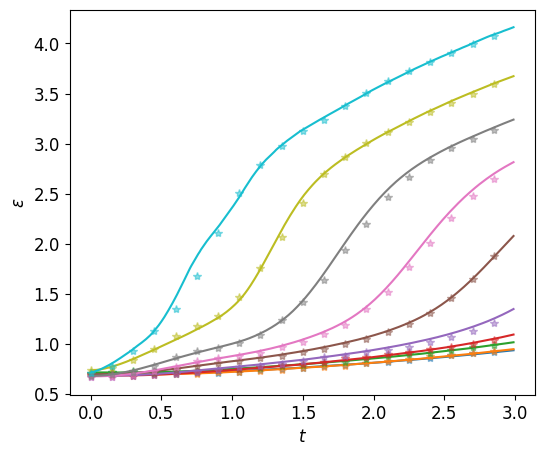

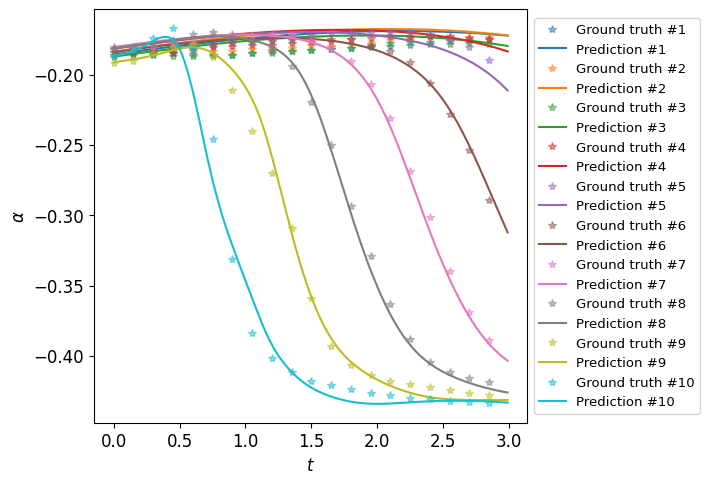

In [13]:
par_start = 0
par_stop = 10
vel_index = 7

# training set & test set
eps_true, internal_var_true, eps_nn, internal_var_nn = model.solve_OVP(X[vel_index:vel_index+1,:,:,:,:], Fex[vel_index:vel_index+1,:])
# eps_true, internal_var_true, eps_nn, internal_var_nn = model.solve_OVP(X_sin[:,:,:,:,:], Fex_sin[:,:])

c_set = list(mcolors.TABLEAU_COLORS)
plt.figure(figsize=(6,5))
for par_index in range(par_start,par_stop):
    th = eps_true.shape[1] - 1 
    plt.plot(t[:th],eps_true[0,:th,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index-par_start],label='Ground truth #' + str(par_index))
    plt.plot(t[:th],eps_nn[0,:th,par_index,0],color=c_set[par_index-par_start],label='Prediction #' + str(par_index))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\varepsilon$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(7.2,5))
for par_index in range(par_start,par_stop):
    th = eps_true.shape[1] - 1    
    plt.plot(t[:th],internal_var_true[0,:th,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index-par_start],label='Ground truth #' + str(par_index+1))
    plt.plot(t[:th],internal_var_nn[0,:th,par_index,0],color=c_set[par_index-par_start],label='Prediction #' + str(par_index+1))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=9.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

r_L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum() / np.square(eps_true[:,1:,:,0]).sum())
r_L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum() / np.square(internal_var_true[:,1:,:,0]).sum())

# print("Sinusoidal protocol")
# print("Relative L2 error of eps: "+str(100*r_L2_err_eps) + "%")
# print("Relative L2 error of alpha: "+str(100*r_L2_err_alpha) + "%")

In [14]:
# L2 error
L2_err_index = onp.linspace(2,18,9,dtype=int) # training

num_ic_par = L2_err_index.size * 10

# training set 
eps_true, internal_var_true, eps_nn, internal_var_nn = model.solve_OVP(X[L2_err_index,:,:,:,:], Fex[L2_err_index,:])

L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_eps = np.sqrt((np.square(eps_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

print("Training set")
print("Relative L2 error of eps: "+str(100*L2_err_eps/L2_nrm_eps) + "%")
print("Relative L2 error of alpha: "+str(100*L2_err_alpha/L2_nrm_alpha) + "%")

#######################################################
L2_err_index = onp.linspace(3,17,8,dtype=int) # test

num_ic_par = L2_err_index.size * 10

# test set 
eps_true, internal_var_true, eps_nn, internal_var_nn = model.solve_OVP(X[L2_err_index,:,:,:,:], Fex[L2_err_index,:])

L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_eps = np.sqrt((np.square(eps_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

print("Test set")
print("Relative L2 error of eps: "+str(100*L2_err_eps/L2_nrm_eps) + "%")
print("Relative L2 error of alpha: "+str(100*L2_err_alpha/L2_nrm_alpha) + "%")

Training set
Relative L2 error of eps: 1.2114867%
Relative L2 error of alpha: 2.2869904%
Test set
Relative L2 error of eps: 1.082914%
Relative L2 error of alpha: 2.242934%


### Learn $F_{ex}$

In [15]:
class learn_F():
    
    def __init__(self, params, layers_Fex, key = random.PRNGKey(0)):
        # initialize nn
        self.nn_Fex = MLP(layers_Fex)
        self.params_F = self.nn_Fex.init(key, np.ones([3]))
        self.key = key

        # initialize optimizer
        self.opt_init, self.opt_update = optax.adam(1e-4)
        self.opt_state = self.opt_init(self.params_F)

        # log
        self.loss_log = []

        # retrieve params
        self.params_encoder = params['encoder']
        self.params_encoder2 = params['encoder2']
        self.params_fe = params['fe']
        self.params_phi = params['phi']
        self.internal_var = (model.nn_encoder.apply(self.params_encoder, model.X_scaled)).mean(axis=3)
        self.internal_var = model.nn_encoder2.apply(self.params_encoder2, self.internal_var)

        self.loss = jit(self._loss)
        self.step = jit(self._step)
        self.jit_net_F = jit(self.net_F)
        self.VONNs_drv = jit(model.VONNs_drv)
        self.calc_traj = jit(self._calc_traj)

        # normalizing factors
        self.norm_fac_fe = model.eps_mean, model.eps_std, model.internal_var_mean, model.internal_var_std, model.fe_scale, model.mean_zero, model.internal_var_zero 
        self.norm_fac_phi = model.eps_mean, model.eps_std, model.internal_var_mean, model.internal_var_std, \
                    model.g_vel_mean, model.g_vel_scale, model.g_internal_var_dot_mean, model.g_internal_var_dot_scale, model.phi_scale, model.g_zero
        self.norm_fac_F = model.eps_mean, model.eps_std, model.internal_var_mean, model.internal_var_std, model.vel.mean(), model.vel.std(), model.Fex.std()

    def net_F(self, params, params_fe, eps, alpha, v, norm_fac_fe, norm_fac_F, sys_const):
        # dfe_deps
        _L0, _eta, _ = sys_const
        dfe_deps = model.vec_calc_dfe_deps(params_fe, eps, alpha, norm_fac_fe)
        F = dfe_deps / _L0 + _eta * v
        # NN to fit dphi_dvel
        eps_mean, eps_std, alpha_mean, alpha_std, v_mean, v_std, F_scale = norm_fac_F
        eps = (eps - eps_mean) / eps_std
        alpha = (alpha - alpha_mean) / alpha_std
        v = (v - v_mean) / v_std
        inputs = np.concatenate([eps, alpha, v],axis=-1)
        F = F + self.nn_Fex.apply(params, inputs) * 1e-4 # F_scale 
        return F
    
    # function of the scan loop
    def time_int(self, states, _vel):
        params_F, params_fe, params_phi, eps, alpha, norm_fac_fe, norm_fac_phi, norm_fac_F, sys_const = states  
        _L0, _, _dt = sys_const 
        # calc Fex 
        Fex_temp = self.jit_net_F(params_F, params_fe, eps[:,:,-1:,:], alpha[:,:,-1:,:], _vel[:,:,:,None], norm_fac_fe, norm_fac_F, sys_const)
        # calc derivatives
        eps_dot_nn, alpha_dot_nn = self.VONNs_drv(params_fe, params_phi, eps, alpha, Fex_temp[:,:,:,0], norm_fac_fe, norm_fac_phi, _L0)
        # update states
        eps = eps + eps_dot_nn * _dt
        alpha = alpha + alpha_dot_nn * _dt
        return (params_F, params_fe, params_phi, eps, alpha, norm_fac_fe, norm_fac_phi, norm_fac_F, sys_const), (eps, alpha, Fex_temp) 

    def _calc_traj(self, init, _vel):
        _, (eps_nn, alpha_nn, Fex_nn) = scan(self.time_int, init, np.transpose(_vel[:,1:,:,:],axes=[1,0,2,3]))
        eps_nn = np.transpose(eps_nn[:,:,0,:,:],axes=[1,0,2,3])
        alpha_nn = np.transpose(alpha_nn[:,:,0,:,:],axes=[1,0,2,3])
        Fex_nn = np.transpose(Fex_nn[:,:,0,:,:],axes=[1,0,2,3])
        return eps_nn, alpha_nn, Fex_nn
    
    def _loss(self, params, batch):
        norm_fac_fe, norm_fac_phi, norm_fac_F, params_fe, params_phi, eps, alpha, _Fex, _vel, sys_const = batch
        init = params, params_fe, params_phi, eps[:,:1,:,:], alpha[:,:1,:,:], norm_fac_fe, norm_fac_phi, norm_fac_F, sys_const
        eps_nn, alpha_nn, Fex_nn = self.calc_traj(init, _vel)
        loss_eps = ((eps[:,1:,:,:] - eps_nn)**2).mean()
        loss_alpha = ((alpha[:,1:,:,:] - alpha_nn)**2).mean()
        loss_Fex = ((_Fex[:,1:,:,:] - Fex_nn)**2).mean()
        return loss_eps + loss_alpha + 10.0*loss_Fex

    def _step(self, params, opt_state, batch):
        loss_value, grads = value_and_grad(self.loss)(params, batch)
        updates, opt_state = self.opt_update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    def train(self, n_epochs, n_batch):
        # main loop
        pbar = trange(n_epochs)
        for i in pbar:
            self.key, _ = random.split(self.key)
            id = random.randint(self.key, (1,), minval=0, maxval=model.Nu)[0]
            id_t = random.randint(self.key, (1,), minval=0, maxval=model.Nt-n_batch)[0]
            batch = self.norm_fac_fe, self.norm_fac_phi, self.norm_fac_F, self.params_fe, self.params_phi, model.mean[id:id+1,id_t:id_t+n_batch,:,:], self.internal_var[id:id+1,id_t:id_t+n_batch,:,:], \
                    model.Fex[id:id+1,id_t:id_t+n_batch,:,:], model.vel[id:id+1,id_t:id_t+n_batch,-1:,:], [model.L0, model.eta, model.delta_t]         
            self.params_F, self.opt_state, loss_value = self.step(self.params_F, self.opt_state, batch)
            if i % 100 == 0:
                print("\n loss = {}".format(loss_value))
                self.loss_log.append(loss_value)

    def get_Fex_training(self):
        Fex_prediction = self.net_F(self.params_F, self.params_fe, model.mean[:,:,-1:,:], self.internal_var[:,:,-1:,:], model.vel[:,:,-1:,:], self.norm_fac_fe, self.norm_fac_F, [model.L0, model.eta, model.delta_t])
        return Fex_prediction

    def solve_OVP_vel(self, X_input, _vel):  
        # calc internal_var and mean
        eps = X_input.mean(axis=-2)
        alpha = (model.nn_encoder.apply(self.params_encoder, (X_input-model.X_mean)/model.X_std)).mean(axis=-2)
        alpha = model.nn_encoder2.apply(self.params_encoder2, alpha)
        # normalizing factors
        sys_const = model.L0, model.eta, model.delta_t
        init = self.params_F, self.params_fe, self.params_phi, eps[:,:1,:,:], alpha[:,:1,:,:], self.norm_fac_fe, self.norm_fac_phi, self.norm_fac_F, sys_const
        eps_nn, alpha_nn, Fex_nn = self.calc_traj(init, _vel)
        return eps, alpha, eps_nn, alpha_nn, Fex_nn

In [16]:
model_F = learn_F(model.params, [3,16,16,1]) 
# model_F.train(n_epochs=100000, n_batch=300)

In [178]:
# import pickle
# FolderName = './data/IB-VONNs-CNF/'
# FileName= 'IB_VONNs_CNF_params_F'
# with open(FolderName+FileName, 'wb') as fp:
#     pickle.dump(model_F.params_F, fp)

In [17]:
import pickle
FolderName = './data/IB-VONNs-CNF/'
FileName= 'IB_VONNs_CNF_params_F'
with open(FolderName + FileName, 'rb') as fp:
    params_temp = pickle.load(fp)
model_F.opt_state = model_F.opt_init(params_temp)
model_F.params_F = params_temp

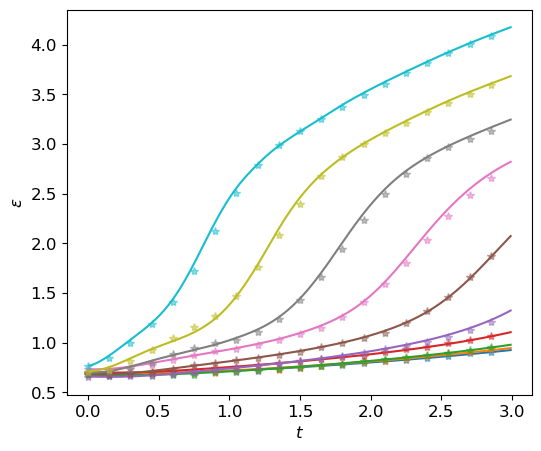

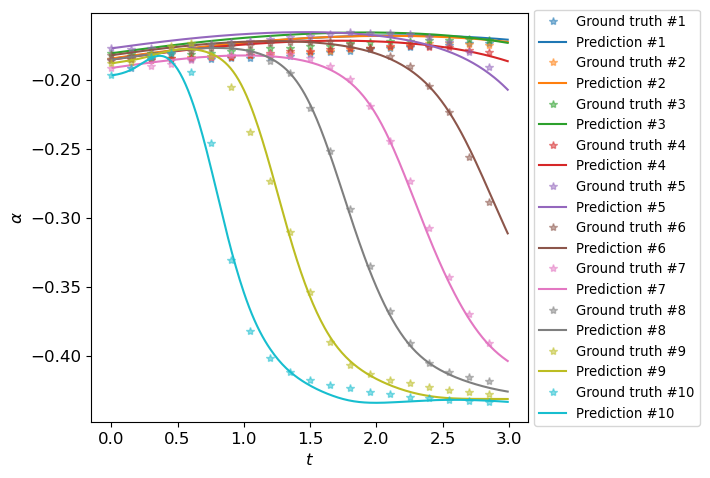

In [209]:
par_start = 0
par_stop = 10
vel_index = 7

# training set & test set
eps_true, internal_var_true, eps_nn, internal_var_nn, F_ex_nn = model_F.solve_OVP_vel(X[vel_index:vel_index+1,:,:,:,:], vel[vel_index:vel_index+1,1:,-1:, None])

c_set = list(mcolors.TABLEAU_COLORS)
plt.figure(figsize=(6,5))
for par_index in range(par_start,par_stop):
    th = eps_true.shape[1] - 1 
    plt.plot(t[:th],eps_true[0,:th,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index-par_start],label='Ground truth ' + str(par_index))
    plt.plot(t[1:th],eps_nn[0,:th,par_index,0],color=c_set[par_index-par_start],label='Prediction ' + str(par_index))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\varepsilon$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(7.2,5))
for par_index in range(par_start,par_stop):
    th = eps_true.shape[1] - 1    
    plt.plot(t[:th],internal_var_true[0,:th,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index-par_start],label='Ground truth #' + str(par_index+1))
    plt.plot(t[1:th],internal_var_nn[0,:th,par_index,0],color=c_set[par_index-par_start],label='Prediction #' + str(par_index+1))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=9.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Training set
Relative L2 error of eps: 0.9161983%
Relative L2 error of alpha: 2.0549402%


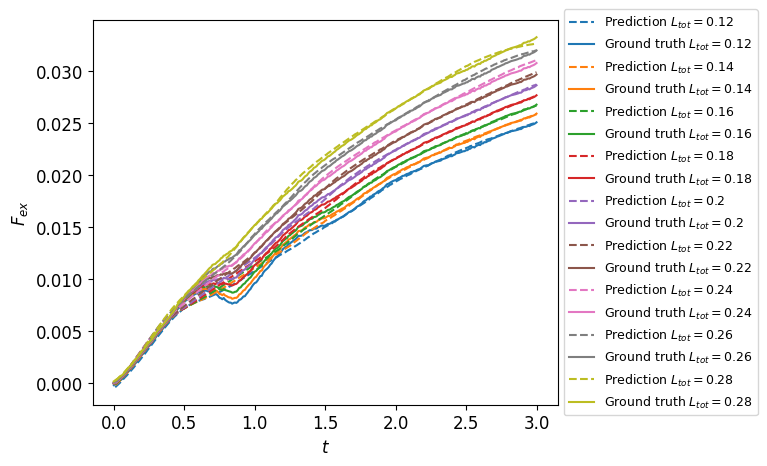

Relative L2 error of Fex: 2.0320358%
Test set
Relative L2 error of eps: 1.0292665%
Relative L2 error of alpha: 2.1130943%


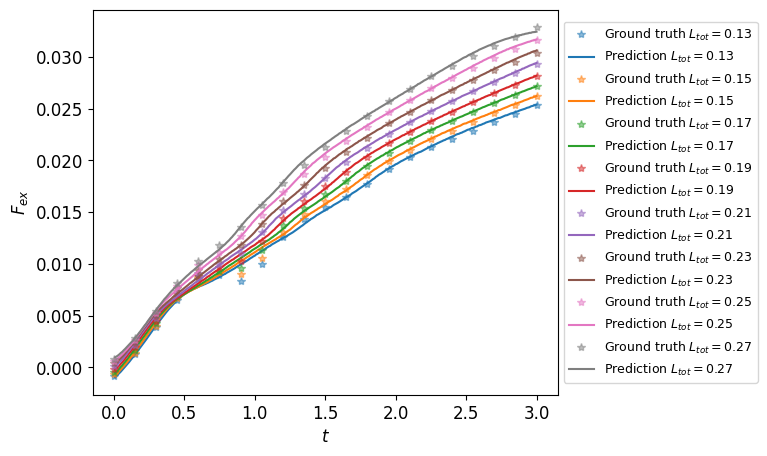

Relative L2 error of Fex: 1.7095642%


In [18]:
# L2 error
L2_err_index = onp.linspace(2,18,9,dtype=int) # training
Ltot_str = ['0.12', '0.14', '0.16', '0.18', '0.2', '0.22', '0.24', '0.26', '0.28']

num_ic_par = L2_err_index.size * 10

# training set 
eps_true, internal_var_true, eps_nn, internal_var_nn, F_ex_nn = model_F.solve_OVP_vel(X[L2_err_index,:,:,:,:], vel[L2_err_index,:,-1:,None])

L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_eps = np.sqrt((np.square(eps_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

r_L2_err_Fex = np.sqrt((np.square(Fex[L2_err_index,1:]-F_ex_nn[:,:,0,0])).sum() / (np.square(Fex[L2_err_index,1:])).sum())

print("Training set")
print("Relative L2 error of eps: "+str(100*L2_err_eps/L2_nrm_eps) + "%")
print("Relative L2 error of alpha: "+str(100*L2_err_alpha/L2_nrm_alpha) + "%")

c_set = list(mcolors.TABLEAU_COLORS)
plt.figure(figsize=(6,5))
for i in range(L2_err_index.shape[0]):
    plt.plot(t[1:], F_ex_nn[i,:,0,0],'--',color=c_set[i],label='Prediction '+r'$L_{tot}=$'+Ltot_str[i])
    plt.plot(t, Fex[L2_err_index[i],:],color=c_set[i],label='Ground truth '+r'$L_{tot}=$'+Ltot_str[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$F_{ex}$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print("Relative L2 error of Fex: "+str(100*r_L2_err_Fex) + "%")

#######################################################
L2_err_index = onp.linspace(3,17,8,dtype=int) # test
Ltot_str = ['0.13', '0.15', '0.17', '0.19', '0.21', '0.23', '0.25', '0.27']

num_ic_par = L2_err_index.size * 10

# test set 
eps_true, internal_var_true, eps_nn, internal_var_nn, F_ex_nn = model_F.solve_OVP_vel(X[L2_err_index,:,:,:,:], vel[L2_err_index,:,-1:,None])

L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_eps = np.sqrt((np.square(eps_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum()*model.delta_t/num_ic_par)
L2_nrm_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0])).sum()*model.delta_t/num_ic_par)

r_L2_err_Fex = np.sqrt((np.square(Fex[L2_err_index,1:]-F_ex_nn[:,:,0,0])).sum() / (np.square(Fex[L2_err_index,1:])).sum())

print("Test set")
print("Relative L2 error of eps: "+str(100*L2_err_eps/L2_nrm_eps) + "%")
print("Relative L2 error of alpha: "+str(100*L2_err_alpha/L2_nrm_alpha) + "%")

plt.figure(figsize=(6,5))
for i in range(L2_err_index.shape[0]):
    # plt.plot(t[1:], F_ex_nn[i,:,0,0],'--',color=c_set[i],label='Prediction '+str(i+1))
    plt.plot(t, Fex[L2_err_index[i],:],'*',markevery=15,alpha=0.5,color=c_set[i],label='Ground truth '+r'$L_{tot}=$'+Ltot_str[i])
    plt.plot(t[1:], F_ex_nn[i,:,0,0],color=c_set[i],label='Prediction '+r'$L_{tot}=$'+Ltot_str[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$F_{ex}$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print("Relative L2 error of Fex: "+str(100*r_L2_err_Fex) + "%")

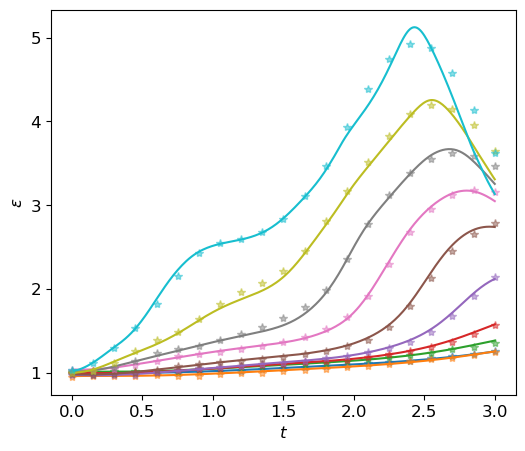

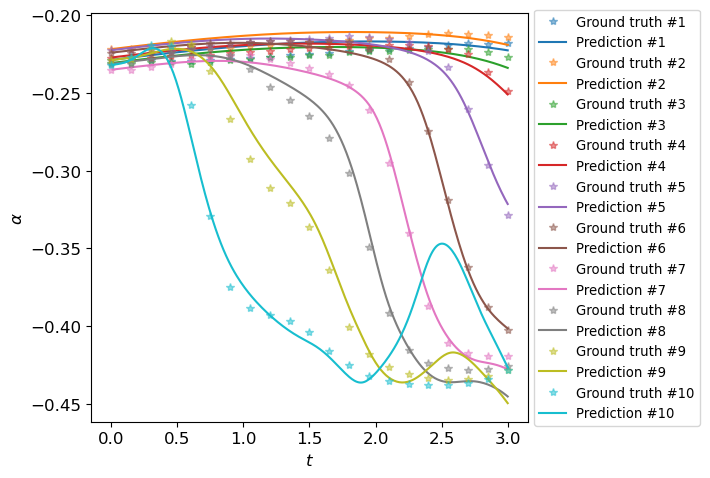

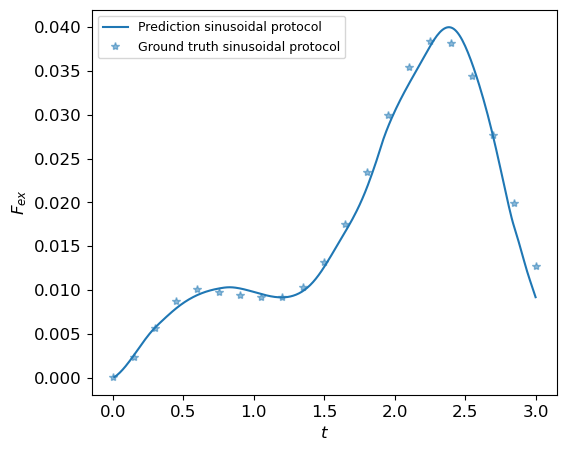

Sinusoidal protocol
Relative L2 error of eps: 3.3497784%
Relative L2 error of alpha: 4.3054385%
Relative L2 error of Fex: 5.998757%


In [16]:
eps_true, internal_var_true, eps_nn, internal_var_nn, F_ex_nn = model_F.solve_OVP_vel(X_sin, vel_sin[:,:,-1:,None])

c_set = list(mcolors.TABLEAU_COLORS)
plt.figure(figsize=(6,5))
for par_index in range(10): 
    plt.plot(t,eps_true[0,:,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index],label='Ground truth ' + str(par_index))
    plt.plot(t[1:],eps_nn[0,:,par_index,0],color=c_set[par_index],label='Prediction ' + str(par_index))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\varepsilon$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(7.2,5))
for par_index in range(10):   
    plt.plot(t,internal_var_true[0,:,par_index,0],'*',markevery=15,alpha=0.5,color=c_set[par_index],label='Ground truth #' + str(par_index+1))
    plt.plot(t[1:],internal_var_nn[0,:,par_index,0],color=c_set[par_index],label='Prediction #' + str(par_index+1))
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$\alpha$', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=9.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.plot(t[1:], F_ex_nn[0,:,0,0],color=c_set[0],label='Prediction sinusoidal protocol')
plt.plot(t, Fex_sin[0,:],'*',markevery=15,alpha=0.5,color=c_set[0],label='Ground truth sinusoidal protocol')
plt.legend(fontsize=9)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$F_{ex}$',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

r_L2_err_eps = np.sqrt((np.square(eps_true[:,1:,:,0]-eps_nn[:,:,:,0])).sum() / np.square(eps_true[:,1:,:,0]).sum())
r_L2_err_alpha = np.sqrt((np.square(internal_var_true[:,1:,:,0]-internal_var_nn[:,:,:,0])).sum() / np.square(internal_var_true[:,1:,:,0]).sum())
r_L2_err_Fex = np.sqrt((np.square(Fex_sin[0,1:]-F_ex_nn[0,:,0,0])).sum() / np.square(Fex_sin[0,1:]).sum())

print("Sinusoidal protocol")
print("Relative L2 error of eps: "+str(100*r_L2_err_eps) + "%")
print("Relative L2 error of alpha: "+str(100*r_L2_err_alpha) + "%")
print("Relative L2 error of Fex: "+str(100*r_L2_err_Fex) + "%")